In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import gzip
%matplotlib inline
np.set_printoptions(suppress=True)

In [3]:
# state formulation:
# ye, psie, w, v, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay
def initial_state(ye, psie, w, v, k, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay):
    return np.float32([ye, psie, w, v, k, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay])

#x = initial_state(0, 0, 0, 0, 0, 100, 1, 0.5, 0.5)
x = initial_state(5, -0.1, 0.01, 5, 0.01, 2, 0, -0.3, -0.3, 0, 0, 0, 0)


In [4]:
from numpy import exp, sin, cos, tan

def kalman_update_input(x0, P, u, dt):
    ''' state prediction given input; returns new state and covariance '''
    ye, psie, w, v, k, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay = x0
    u_acceleration, u_steering = u
    
    eCv, eTv, eCs, eTs = exp(Cv), exp(Tv), exp(Cs), exp(Ts)

    # k_est, k_var, k_grad = curvature_mean_grad_var(s, P[0, 0])

    x = np.float32([
            ye - dt*v * sin(psie),
            psie + dt*(w + v * k * cos(psie) / (1 - k * ye)),
            w + dt*(v*eCs*(u_steering - mu_s) - w) / eTs,
            v + dt*(eCv * u_acceleration - v) / eTv,
            k, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay
        ])
    
    Fk_1 = np.float32([
            [1, -dt*v*cos(psie), 0, -dt*sin(psie), 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [dt*k**2*v*cos(psie)/(k*ye - 1)**2, (dt*k*v*sin(psie) + k*ye - 1)/(k*ye - 1), dt, -dt*k*cos(psie)/(k*ye - 1), dt*v*cos(psie)/(k*ye - 1)**2, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, -dt*exp(-Ts) + 1, -dt*(mu_s - u_steering)*exp(Cs - Ts), 0, 0, 0, -dt*v*(mu_s - u_steering)*exp(Cs - Ts), dt*(v*(mu_s - u_steering)*exp(Cs) + w)*exp(-Ts), -dt*v*exp(Cs - Ts), 0, 0, 0],
            [0, 0, 0, -dt*exp(-Tv) + 1, 0, dt*u_acceleration*exp(Cv - Tv), dt*(-u_acceleration*exp(Cv) + v)*exp(-Tv), 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

    # print >>kalman_log, 'f', x0[:5], '->', x[:5]
    #Q = np.diag([v*dt*0.001, v*dt*0.00001, v*dt*0.001, dt*0.1, v*dt*0.01, 0, 0, 0, 0])**2  # process noise

    v = 0.5 + np.abs(x[3])  # use velocity to determine process noise magnitudes
    Qk_1 = np.diag([  # process noise
            v*dt*0.1,  # ye shouldn't jitter much at all unless we are skidding
            v*dt*0.1,  # neither should psie
            v*dt*0.2,  # angular steering should mostly be correct from controls but give it slack
            dt*0.006,   # same with velocity
            v*dt*0.1,  # curvature distribution was computed above
            1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4])  # the remainder are undetermined constants
    # print >>kalman_log, 'Q', np.diag(Qk_1)
    
    # print >>kalman_log, 'F\n', Fk_1
    P = np.dot(Fk_1, np.dot(P, Fk_1.T)) + Qk_1
    # print >>kalman_log, 'Qk\n', Qk_1
    # print >>kalman_log, 'predict P\n', P

    return x, P

kalman_update_input(x, np.eye(len(x)), [0, 0], 1.0/30)[0]

array([ 5.01663876, -0.09792104,  0.00955005,  4.83333349,  0.01      ,
        2.        ,  0.        , -0.30000001, -0.30000001,  0.        ,
        0.        ,  0.        ,  0.        ], dtype=float32)

In [5]:
def h_centerline(x):
    ''' return predicted centerline intercept and slope given state '''
    ye, psie, w, v, k, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay = x
    x_CG = 0.20  # CG is about 20cm behind camera
    hk = np.float32([(ye + x_CG*np.tan(psie)) / np.cos(psie), np.tan(psie), -2*k])
    Hk = np.float32([
            [1/cos(psie), (x_CG - 2*x_CG/cos(psie)**2 + ye*tan(psie))/cos(psie), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, cos(psie)**(-2), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, -2, 0, 0, 0, 0, 0, 0, 0, 0]
        ])
    return hk, Hk

h_centerline(x)

(array([ 5.0049367 , -0.10033467, -0.02      ], dtype=float32),
 array([[ 1.00502086, -0.70924342,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  1.01006699,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        , -2.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ]], dtype=float32))

In [6]:
def h_imu(x, u):
    ''' return predicted IMU measurements from state '''
    ye, psie, w, v, k, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay = x
    u_acceleration, u_steering = u
    
    # we need to steal the acceleration input here; this just shortcuts having an explicit
    # acceleration held in the state

    hk = np.float32([
            w + mu_g,
            v*w + mu_ax,
            -(exp(Cv) * u_acceleration - v) / exp(Tv) + mu_ay,
        ])
    Hk = np.float32([
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, v, w, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, exp(-Tv), 0, -u_acceleration*exp(Cv - Tv), (u_acceleration*exp(Cv) - v)*exp(-Tv), 0, 0, 0, 0, 0, 1]
        ])
    return hk, Hk

h_imu(x, [0, 0])

(array([ 0.01,  0.05,  5.  ], dtype=float32),
 array([[ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ,  1.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  5.  ,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  1.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  , -5.  ,  0.  ,  0.  ,
          0.  ,  0.  ,  0.  ,  1.  ]], dtype=float32))

In [7]:
# 2560x1920 camera matrix -> 640x480 * 4 -> 320x240 * 8
#camera_matrix = np.float32([
#    [  1.32671284e+03,  0.00000000e+00,  1.17056274e+03],
#    [  0.00000000e+00,  1.32325908e+03,  8.93906010e+02],
#    [  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
#
#dist_coeffs = np.float32([-0.02673142, 0, 0, 0])

camera_matrix = np.float32([
    [  1.07384901e+03,  0.00000000e+00,  1.22267553e+03],
    [  0.00000000e+00,  1.06616220e+03,  9.42042213e+02],
    [  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

dist_coeffs = np.float32([-0.02081262, 0, 0, 0])

camera_matrix[:2] /= 8.

new_camera_matrix = np.float32([  # ~1mm/pixel on ground
        [-143, 0, 160],
        [0, 143, 240],
        [0, 0, 1]
    ])

birdseye_camera_matrix = np.copy(new_camera_matrix)  # 1m on ground per unit
birdseye_camera_matrix[:2, :2] *= 0.1

m_to_birdseye_matrix = np.float32([  # from meter scale to 100px/meter scale
        [-100, 0, 160],
        [0, 100, 240],
        [0, 0, 1]
    ])


# camera is now angled down about 0.30 radians
Rdown = cv2.Rodrigues(np.float32([-np.pi/2 - 0.30, 0, 0]))[0]

#Rdown = cv2.Rodrigues(np.float32([-0.075, 0, 0]))[0]
udm1, udm2 = cv2.fisheye.initUndistortRectifyMap(
    camera_matrix, dist_coeffs, Rdown, new_camera_matrix, (320, 240), cv2.CV_16SC2)
print udm1.shape, udm2.shape
# udm1, udm2 are reverse lookups: udm1[y, x] is the location of the pixel in the camera image
# which maps to x, y in the target image

# undistort_map is the forward lookup: undistort_map[y, x] contains the virtual pinhole camera
# coordinate of the real fisheye camera pixel x, y
undistort_map = cv2.fisheye.undistortPoints(
    np.mgrid[:320, :240].T.astype(np.float32),
    camera_matrix, dist_coeffs)

#undistort_map /= 20. / 2.4  # change unit length to cm


(240, 320, 2) (240, 320)


90
[-2.47723508 -0.45311818]


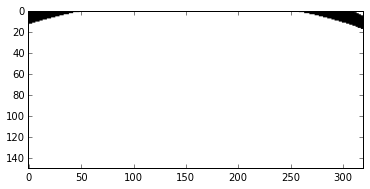

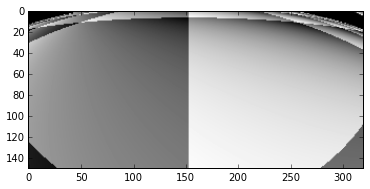

In [17]:
#ytop = 67
ytop = 90
print ytop
print undistort_map[ytop, 0]
udplane = np.dot(np.concatenate([undistort_map, np.ones((240, 320, 1))], axis=2), Rdown.T)[ytop:]

udplane[:, :, 0] /= udplane[:, :, 2]
udplane[:, :, 1] /= udplane[:, :, 2]
udplane[:, :, :2] *= new_camera_matrix[1,1] / 1000.  # udplane is now in cm
udmask = (udplane[:, :, 1] < 1) & (np.sqrt(udplane[:, :, 0]**2 + udplane[:, :, 1]**2) < 5)
plt.imshow(udmask, cmap='gray')
plt.show()
#print udplane[-1]
udplane[udmask^True, :] = 0
plt.imshow((udplane[:, :, 0]%1) + (udplane[:, :, 1]%1), 'gray')
np.savetxt("udplane.txt", udplane[:, :, :2].reshape(-1), newline=",\n")
np.savetxt("udmask.txt", udmask.reshape(-1), newline=",\n")


In [342]:
udmask[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [343]:
udm1, udm2 = cv2.fisheye.initUndistortRectifyMap(
    camera_matrix, dist_coeffs, Rdown, birdseye_camera_matrix, (320, 240), cv2.CV_16SC2)
print udm1.shape, udm2.shape


(240, 320, 2) (240, 320)


In [366]:
def kalman_update_cam(img, x, P, mask, dt):
    N = len(nz[0])
    if N < 20:
        return x, P

    # measure line slope / position
    nzt = udplane[nz]  # undistort coordinates
    X = np.vstack([np.ones(N), nzt[:,1], nzt[:,1]**2]).T  # 1, screen y is X
    y = nzt[:,0]   # screen x coords are y in our regression
    B = np.linalg.lstsq(np.dot(X.T, X), np.dot(X.T, y))[0]
    if np.any(np.isnan(B)) or np.any(np.isinf(B)):
        print "warning: ignoring camera update w/ inf regression"
        return x, P
    r2 = np.dot(B.T, np.dot(np.dot(X.T, X), B)) - 2*np.dot(np.dot(X, B).T, y) + np.dot(y.T, y)
    # r2 /= N
    Rk = np.linalg.inv(np.dot(X.T, X)) * r2
    # print 'mb_Rk\n', Rk
    # Rk[1, 1] += 0.01  # slope is just iffy in general
    t = np.linspace(0, -2, 10)
    pts = np.vstack([B[0] + t*B[1] + t*t*B[2], t, np.ones(10)])
    p = np.dot(m_to_birdseye_matrix, pts)
    # draw instantaneous line fit
    for i in range(len(t) - 1):
        cv2.line(img, (int(p[0, i]), int(p[1, i])),
                 (int(p[0, i+1]), int(p[1, i+1])),
                 (255, 255, 255))
    cv2.putText(img, "b%0.3f m%0.3f k%0.4f r%0.4f" % (B[0], B[1], -B[2]/2, r2), (0, 239), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

    # kalman update from line parameters B
    z_k, H_k = h_centerline(x)    
    y_k = (B - z_k)
    S = np.dot(H_k, np.dot(P, H_k.T)) + Rk
    K = np.dot(P, np.dot(H_k.T, np.linalg.inv(S)))
    print >>kalman_log, 'mb_K\n', K
    print >>kalman_log, 'y_k', y_k, 'pred', z_k, 'meas', B
    #print 'K[0]', K[:, 0]
    #print 'K[1]', K[:, 1]
    x += np.dot(K, y_k)

    KHk = np.dot(K, H_k)
    P = np.dot((np.eye(len(x)) - KHk), P)
    # print x[:4]
    # print np.diag(P)[:4]
    
    return x, P


In [345]:
def kalman_update_imu(x, P, u, accel, gyro, dt):
    z_k, H_k = h_imu(x, u)
    # convert accelerometer gs to m/s^2
    accel = 9.8 * accel
    y_k = np.float32([gyro[2], accel[0], accel[1]]) - z_k

    # accelerometer measurements are hugely noisy, almost not even worth it
    Rk = np.diag([1e-2, 2, 2])**2  # measure the actual noise?
    
    S = np.dot(H_k, np.dot(P, H_k.T)) + Rk
    K = np.dot(P, np.dot(H_k.T, np.linalg.inv(S)))
    print >>kalman_log, 'imu K\n', K
    print >>kalman_log, 'imu y_k', y_k, 'pred', z_k, 'meas', y_k + z_k
    x += np.dot(K, y_k)

    KHk = np.dot(K, H_k)
    P = np.dot((np.eye(len(x)) - KHk), P)

    return x, P


In [346]:
# deprecated; will use a particle filter on s for map matching
# we *could* make a measurement of k from the map, but it's probably best not to
# cause a feedback loop.
# instead, use the kalman filter as a prior distribution P(k) and use the particle filter as
# an estimate of P(s|k); so P(s, k) = P(s|k) * P(k)
# then we can do planning via sampling or just maximum likelihood of s and k.

# or just plan using s, k from the map particle, and the rest of the EKF state for
# everything else.


'''def kalman_update_map(x, P):
    ye, psie, w, v, k, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay = x
    var_s, _, _, _, _, var_k = np.diag(P)[:6]

    # use the map to refine estimate of s
    y_k, R_k = refine_s(s, var_s, k, var_k)
    R_k[1, 1] += 1
    H_k = np.float32([
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
        ])
    
    S = np.dot(H_k, np.dot(P, H_k.T)) + R_k
    K = np.dot(P, np.dot(H_k.T, np.linalg.inv(S)))
    print >>kalman_log, 'trackmap h_k', s, '+-', np.sqrt(var_s), ',', k, '+-', np.sqrt(var_k)
    print >>kalman_log, 'trackmap K\n', K
    print >>kalman_log, 'trackmap R_k\n', R_k
    print >>kalman_log, 'trackmap S_k\n', S
    print >>kalman_log, 'trackmap y_k', y_k

    x += np.dot(K, y_k)

    KHk = np.dot(K, H_k)
    P = np.dot((np.eye(len(x)) - KHk), P)

    return x, P
    '''


"def kalman_update_map(x, P):\n    ye, psie, w, v, k, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay = x\n    var_s, _, _, _, _, var_k = np.diag(P)[:6]\n\n    # use the map to refine estimate of s\n    y_k, R_k = refine_s(s, var_s, k, var_k)\n    R_k[1, 1] += 1\n    H_k = np.float32([\n            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]\n        ])\n    \n    S = np.dot(H_k, np.dot(P, H_k.T)) + R_k\n    K = np.dot(P, np.dot(H_k.T, np.linalg.inv(S)))\n    print >>kalman_log, 'trackmap h_k', s, '+-', np.sqrt(var_s), ',', k, '+-', np.sqrt(var_k)\n    print >>kalman_log, 'trackmap K\n', K\n    print >>kalman_log, 'trackmap R_k\n', R_k\n    print >>kalman_log, 'trackmap S_k\n', S\n    print >>kalman_log, 'trackmap y_k', y_k\n\n    x += np.dot(K, y_k)\n\n    KHk = np.dot(K, H_k)\n    P = np.dot((np.eye(len(x)) - KHk), P)\n\n    return x, P\n    "

track distance 30.6 spacing 0.2


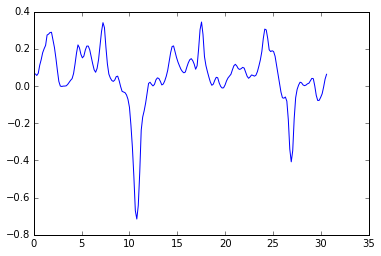

In [347]:
# the track map was originally set up on an image with a lane width of about 40 pixels
# corresponding to 1.8 meters
MAP_SCALE = 1.8/40  # meters / map unit

MAP_SPACING = MAP_SCALE*11  # inter-point spacing in meters (is 11 in map units)
# (5.88 track units / meter) / (11 track units / space)
# = x meters / space
# divide curvature (1/mapunit) by MAP_SCALE to get (1/meters)

trackmap_curvature = 0.5 * np.float32([  # i don't know why i need to fudge this by 1/2
       -0.00005514, -0.00006868, -0.00009158, -0.00013434, -0.00023168,
       -0.00046061,  0.00194107,  0.00023285, -0.00148094, -0.00319153,
       -0.00486674, -0.0067554 , -0.01304177, -0.00786357, -0.00479418,
       -0.00248969, -0.00486794, -0.01631333, -0.00698942, -0.00072471,
        0.00539643,  0.01291206,  0.01675034,  0.02363724,  0.0206228 ,
        0.03207364,  0.01813854,  0.01414216,  0.02136572,  0.02705863,
        0.01503912,  0.01166399,  0.01518489,  0.02251603,  0.02793345,
        0.01669162,  0.01882312,  0.02879992,  0.00858401,  0.00351843,
        0.00151938,  0.00023876, -0.00106178, -0.00246747,  0.0011578 ,
        0.00099443,  0.00079809,  0.00057129,  0.0003187 ,  0.00004707,
       -0.00023509, -0.00051808, -0.0007918 , -0.00104664, -0.0012743 ,
       -0.00676779, -0.01105019, -0.00931596, -0.00762937, -0.00609633,
       -0.00640101, -0.00762116, -0.00780885, -0.0082183 , -0.00884384,
       -0.00716877, -0.00244946, -0.00184087, -0.00139999, -0.00104898,
       -0.00073532, -0.00040824,  0.0000118 ,  0.00068169,  0.02411683,
        0.05136439,  0.08238694,  0.03717972,  0.01340399,  0.00649472,
        0.00228229,  0.00098088,  0.00037734, -0.00004254,  0.00271266,
        0.00513409,  0.00607055,  0.01094126,  0.01264397,  0.01057568,
        0.01291   ,  0.01362091,  0.0128938 ,  0.0113266 ,  0.01320195,
        0.0171448 ,  0.01392724,  0.0112788 ,  0.0094803 ,  0.00883845,
        0.00014593, -0.00004646, -0.00004311, -0.00004702]) / MAP_SCALE

MAP_SCALE = 1
MAP_SPACING = 0.20  # 20 cm spacing

trackmap_curvature = np.float32([
        6.71627167e-02,   6.54640293e-02,   4.77807895e-02,
         1.12032655e-01,   1.45301417e-01,   2.00077208e-01,
         2.02842012e-01,   2.87154073e-01,   2.74166357e-01,
         3.04080144e-01,   2.46089248e-01,   1.98528924e-01,
         1.08559329e-01,   2.15079543e-02,  -6.12811366e-03,
        -4.26415923e-04,  -4.68766323e-04,   6.94816010e-05,
         1.16261690e-02,   2.97550639e-02,   3.64991561e-02,
         7.27531680e-02,   1.56630703e-01,   2.31087352e-01,
         2.02508410e-01,   1.48798964e-01,   1.52410904e-01,
         1.98627946e-01,   2.23022501e-01,   2.05759283e-01,
         1.55154388e-01,   1.09360246e-01,   6.58350240e-02,
         8.83356002e-02,   1.48038073e-01,   2.61532754e-01,
         3.51532742e-01,   3.20840469e-01,   1.57536799e-01,
         6.52304636e-02,   4.22950209e-02,   2.51563835e-02,
         2.36187770e-02,   5.23029966e-02,   5.59284543e-02,
         1.13526929e-02,  -3.11396602e-02,  -3.24145536e-02,
        -3.66376402e-02,  -6.24694450e-02,  -1.06670115e-01,
        -2.39383988e-01,  -4.11360654e-01,  -6.89394349e-01,
        -7.30960985e-01,  -5.90502348e-01,  -2.26592277e-01,
        -1.58138893e-01,  -1.23019147e-01,  -5.00972111e-02,
         2.29463109e-02,   2.01609803e-02,  -2.19712561e-03,
         4.61595858e-03,   4.01443884e-02,   4.69388097e-02,
         2.89347770e-02,  -2.72411918e-05,   1.50384258e-02,
         4.47409332e-02,   8.25356456e-02,   1.47911558e-01,
         2.11458300e-01,   2.22095229e-01,   1.76360665e-01,
         1.36636437e-01,   1.10539954e-01,   8.68817464e-02,
         7.29040773e-02,   6.70894559e-02,   1.03318212e-01,
         1.31915927e-01,   1.51203758e-01,   1.38538267e-01,
         1.15079231e-01,   6.87103246e-02,   1.81409908e-01,
         3.24595944e-01,   3.61714234e-01,   1.59915040e-01,
         1.06275917e-01,   6.76596803e-02,   2.72768650e-02,
        -3.98173001e-05,   1.05792281e-02,   4.57653033e-02,
         5.12183699e-02,   1.09412953e-02,  -9.31988457e-03,
        -1.38116229e-02,   5.27244532e-03,   3.59958810e-02,
         5.13150920e-02,   5.99747074e-02,   9.34674063e-02,
         1.21122627e-01,   1.09639956e-01,   8.97811164e-02,
         8.81276283e-02,   1.01606632e-01,   9.85513720e-02,
         6.51077066e-02,   3.78529182e-02,   4.80721412e-02,
         6.34703887e-02,   5.16424821e-02,   5.44352445e-02,
         7.92617871e-02,   1.22142027e-01,   1.68524750e-01,
         2.63366890e-01,   3.26075232e-01,   2.77472009e-01,
         1.85682446e-01,   1.84203996e-01,   1.94251599e-01,
         1.67912277e-01,   1.03608210e-01,   4.67916866e-02,
        -2.82119950e-02,  -6.92813540e-02,  -6.47489790e-02,
        -5.09923613e-02,  -1.67846986e-01,  -3.90828429e-01,
        -4.29633227e-01,  -1.76697398e-01,  -3.92391845e-02,
        -5.46418161e-03,   2.29392292e-02,   1.79451389e-02,
         6.24793321e-04,   2.51410558e-03,   1.23813972e-02,
         1.45234616e-02,   3.89923252e-02,   4.80602234e-02,
        -6.36562090e-03,  -7.78778067e-02,  -8.14828090e-02,
        -5.97846016e-02,  -3.63693686e-02,   3.02351401e-02])

trackmap_curvature_grad = np.concatenate([
        trackmap_curvature[1:] - trackmap_curvature[:-1],
        [trackmap_curvature[0] - trackmap_curvature[-1]]]) / MAP_SPACING

MAP_LENGTH = len(trackmap_curvature) * MAP_SPACING

def curvature_mean_grad_var(mean_s, var_s):
    ''' return mean, derivative, and variance of curvature given state estimate s '''
    s = np.arange(len(trackmap_curvature)) * MAP_SPACING  # is in meters
    tracklen = len(trackmap_curvature) * MAP_SPACING # meters
    sdist = ((s - mean_s) + tracklen/2) % tracklen - tracklen/2  # wrap distance around track

    ps = np.exp(-sdist**2 / (2 * var_s))
    ps /= np.sum(ps)
    # note we can't use the regular gaussian normalizer here
    mean = np.sum(ps * trackmap_curvature)
    v = np.sum(ps * (trackmap_curvature - mean)**2)
    grad = np.sum(ps * trackmap_curvature_grad)
    return mean, v, grad

print 'track distance', MAP_LENGTH, 'spacing', MAP_SPACING
s = np.linspace(0, len(trackmap_curvature) * MAP_SPACING, 200)
c = np.float32([curvature_mean_grad_var(ds, 0.1**2) for ds in s])
plt.plot(s, c[:, 0])
#plt.plot(s, c[:, 0] - np.sqrt(c[:, 1]))
#plt.plot(s, c[:, 0] + np.sqrt(c[:, 1]))
#plt.plot(s, np.zeros(100))
#plt.plot(s, 10*c[:, 2])

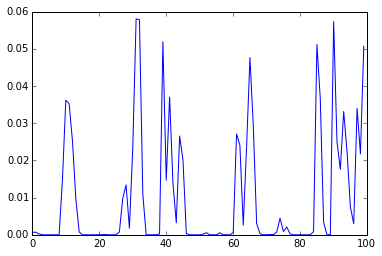

In [348]:
def track_location_prob(state_log):
    s = state_log[:, 0]
    s -= s[-1]
    k = state_log[:, 5]
    Pk = state_log[:, 10]
    prob = np.zeros(100)
    trackpts = len(trackmap_curvature)
    ds = np.linspace(0, TRACK_LEN, 101)[:-1]
    for i in range(len(ds)):
        idxs = np.int32(((s + ds[i]) / MAP_SPACING)) % trackpts
        # print i, idxs
        k_traj = trackmap_curvature[idxs]
        prob[i] = np.sum(-(k - k_traj)**2 / Pk)
        #plt.plot(k_traj)
        #plt.plot(k)
        #plt.show()
        #print i, prob[i]

    prob -= np.max(prob)
    prob = np.exp(prob)
    prob /= np.sum(prob)
    return prob

plt.plot(track_location_prob(np.float32(state_log[-100:])))

In [349]:
TRACK_LEN = len(trackmap_curvature) * MAP_SPACING

def init_particles():
    # initially, evenly space particles along the track
    return np.linspace(0, TRACK_LEN, 1000)

def update_particles(x, P, s_particles, dt):
    ye, psie, w, v, k, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay = x
    trackpts = len(trackmap_curvature)
    
    PU = np.linalg.cholesky(P[:5, :5]).T # upper triangle of chol(P) for sampling

    # first, resample the particles based on their likelihood w.r.t. k, P[k]
    L = len(s_particles)

    # add a uniform sample of particles onto our set, just in case we're ever starved
    #s_particles = np.concatenate([s_particles, np.linspace(0, TRACK_LEN, 50)])
    # ^ that's a stupid idea, because it loses the whole point of having a particle filter
    
    k_particles = trackmap_curvature[np.int32((s_particles / MAP_SPACING) % trackpts)]
    k_var = P[4, 4] * 6
    ps = -(k_particles - k)**2 / (2 * k_var)
    
    ps -= np.max(ps)
    ps = np.exp(ps)
    ps *= L / np.sum(ps)
    r = np.random.rand()
    new_particles = np.zeros(L)
    p, j = 0, 0
    vsum = 0
    # hist = np.zeros(L)
    for i in range(L):
        while r > ps[j]:
            r -= ps[j]
            j += 1
        # hist[j] += 1
        x_sample = x[:5] + np.dot(PU, np.random.randn(5)) * 6
        ye1, psie1, w1, v1, k1 = x_sample
        vsum += v1
        # use curvature from track k_particles[j]? that seems to lead to starvation
        # but it is more correct. hm.
        #new_particles[i] = s_particles[j] + dt * v1 * np.cos(psie1) / (1 - k1 * ye1)
        new_particles[i] = s_particles[j] + dt * v1 * np.cos(psie1) / (1 - k_particles[j] * ye1)
        new_particles[i] %= trackpts * MAP_SPACING
        r += 1
    # print 'new particle mean', np.mean(new_particles), 'vel', v*dt, 'mean sample vel', dt*vsum / L
    # print hist
    
    k_particles = trackmap_curvature[np.int32((new_particles / MAP_SPACING) % trackpts)]
    k_var = P[4, 4]
    ps = -(k_particles - k)**2 / (2 * k_var)
    ps -= np.max(ps)
    ps = np.exp(ps)
    ps *= 1.0 / np.sum(ps)

    return new_particles, ps

# update_particles(x, P, init_particles(), 1.0/30)

In [350]:
print x
print np.sqrt(np.diag(P))

[-0.15204281  0.35151312  0.05725216  0.61676508 -0.04092094  2.19721484
  0.80049348  0.14020237 -1.12976098  0.16871057 -0.05996782 -0.0604765
  0.05177179]
[ 0.85646508  0.59360935  0.08965365  2.38873374  0.0767485   0.1808314
  0.29031433  0.18082118  0.1509797   0.07697814  0.08920759  0.33543808
  0.34844973]


In [355]:
U_THRESH = 112
V_THRESH = 135

In [377]:
capture = open("home0521-7-1.yuv")  # gzip.open("driveway4-1.yuv.gz")

#x = initial_state(0, 0, 0, 0, 0,
#                  np.log(5), 0, np.log(0.3), np.log(0.5),
#                  0, 0, 0, 0)

# linear white line / yellow line / background classifier
yuvw1 = np.array([
    [  7.64430666,   4.79871893,  -6.13509226],
    [  6.2450037 , -19.7711277 ,   5.95682621],
    [ -4.67799187,  14.61457253,  -4.42752457]], dtype=np.float32)

yuvb1 = 128 * (-np.dot([1, 1, 1], yuvw1) +
               np.array([-2.20822358, -6.71973562 - 2,  4.39618778], dtype=np.float32))

x = initial_state(0, 0, 0, 0, 0,  # more accurate initialization of free params w/ hindsight
                 np.log(9), 0.80, 0.14, -1.13, 0.17, -0.21, -0.05055933, 0.05653949)

P = np.diag([2, 1, 0.1, 10, 1,
             0.18, 0.29, 0.18, 0.15, 0.076, 0.17, 0.35, 0.35])**2
s_coord = 0
state_log = []

write_video = False

if write_video:
    out = cv2.VideoWriter("ekf.h264", cv2.VideoWriter_fourcc(
          'X', '2', '6', '4'), 30, (640, 480), True)

kalman_log = open("kalman.log", "w")

prev_ts = None
s_particles = init_particles()
frameno = 0

while True:
    fhdr = 36
    fsize = fhdr + 640*480 + 320*240*2
    frame = np.frombuffer(capture.read(fsize), np.uint8)
    if len(frame) < fsize:
        break
    tstamp = np.frombuffer(np.getbuffer(frame[:8]), np.uint32)
    controls = np.frombuffer(np.getbuffer(frame[8:12]), np.uint16)
    accel = np.frombuffer(np.getbuffer(frame[12:24]), np.float32)
    gyro = np.frombuffer(np.getbuffer(frame[24:36]), np.float32)
    # FIXME: bug workaround: gyro full scale was off by a factor of 4
    # gyro = gyro * 4.0   # not needed with driveway4+
    ts = tstamp[0] + tstamp[1] / 1000000.0

    # hack because i forgot to save autodrive throttle
    # if controls[0] == 614 and controls[1] != 655:
    #     controls = [700, controls[1]]
    controls = np.float32(controls) / 204.8 - 3.0
    # controls[1] = controls[1] - 6500/32768.0  # steering is backwards and has a trim value of ~6500
    # but we want backwards steering as we have w as counterclockwise

    y = frame[fhdr:fhdr+640*480]
    u = np.copy(frame[fhdr+640*480:fhdr+640*480+320*240])
    v = np.copy(frame[fhdr+640*480+320*240:])
    u[u < U_THRESH] = 0
    v[v > V_THRESH] = 255
    cv2.imshow("y", y.reshape(-1, 640))
    cv2.imshow("u", u.reshape(-1, 320))
    cv2.imshow("v", v.reshape(-1, 320))
    img = cv2.cvtColor(frame[fhdr:].reshape((-1, 640)), cv2.COLOR_YUV420P2RGB)
    
    #pixelclass = np.argmax(
    #    yuvw1[0] * y.reshape((480, 640))[::2, ::2]
    #    + yuvw1[1] * u.reshape((240, 320))
    #    + yuvw1[2] * v.reshape((240, 320)) + yuvb1, axis=2)
    #mask = pixelclass[ytop:] == 1

    mask = ((u[ytop*320:] < U_THRESH) & (v[ytop*320:] > V_THRESH)).reshape(-1, 320)
    mask = mask & udmask
    nz = np.nonzero(mask)
    
    img[2*ytop+nz[0]*2, nz[1]*2, 0] = 255
    img[2*ytop+nz[0]*2, nz[1]*2, 1] = 255
    img[2*ytop+nz[0]*2, nz[1]*2, 2] = 0
    #img[mask, 2] = 255
    
    birdseye = cv2.remap(img[::2,::2], udm1, udm2, cv2.INTER_LINEAR)  #, borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255))

    img[:240, :320] = birdseye
    
    dt = 1.0/30
    if prev_ts is not None:
        dt = ts - prev_ts
    prev_ts = ts
    if dt > 0.2:
        print "WARNING: lost time!", dt

    x, P = kalman_update_input(x, P, controls, dt)
    
    x, P = kalman_update_cam(img, x, P, nz, dt)
    
    x, P = kalman_update_imu(x, P, controls, accel, gyro, dt)
    
    # show particle filter locations
    # first graph track curvature
    for i in range(len(trackmap_curvature) - 1):
        x0 = 5 + 630.0*i / len(trackmap_curvature)
        x1 = 5 + 630.0*(i+1) / len(trackmap_curvature)
        cv2.line(img, (int(x0), int(410 + 50*trackmap_curvature[i])),
                 (int(x1), int(410 + 50*trackmap_curvature[i+1])),
                 (0, 255, 255), 1)
                        
    # todo: particle filter update:
    s_coord += dt * x[3] * np.cos(x[1]) / (1 - x[4]*x[0])
    state_log.append([s_coord] + list(x[:5]) + list(np.diag(P)[:5]))
    # compute track likelihood against recent states!
    
    if False:
        ps = track_location_prob(np.float32(state_log[-300:]))
        for i in range(len(ps) - 1):
            x0 = 5 + 630.0*i / len(ps)
            x1 = 5 + 630.0*(i+1) / len(ps)
            cv2.line(img,
                     (int(x0), int(400 - 50*ps[i])),
                     (int(x1), int(400 - 50*ps[i+1])),
                     (255, 0, 0), 1)
    
    #s_particles, ps = update_particles(x, P, s_particles, dt)
    
    if False:
        img[410, np.int32(630 * s_particles / TRACK_LEN + 5), 0] = 255
        img[410, np.int32(630 * s_particles / TRACK_LEN + 5), 1] = 255
        img[410, np.int32(630 * s_particles / TRACK_LEN + 5), 2] = 255
        img[411, np.int32(630 * s_particles / TRACK_LEN + 5), 0] = 0
        img[411, np.int32(630 * s_particles / TRACK_LEN + 5), 1] = 0
        img[411, np.int32(630 * s_particles / TRACK_LEN + 5), 2] = 0
        p_mode = s_particles[np.argmax(ps)]
        p_dist = ((s_particles - p_mode) + TRACK_LEN/2) % TRACK_LEN - TRACK_LEN/2  # wrap distance around track

        p_mean = np.sum(p_dist * ps) + p_mode
        cv2.circle(img, (int(630 * p_mean / TRACK_LEN + 5), 410), 6, 0, 3)
        cv2.circle(img, (int(630 * p_mean / TRACK_LEN + 5), 410), 6, (255, 255, 255), 1)
        cv2.line(img, (5, 405), (5, 415), (0, 0, 0), 5)
        cv2.line(img, (5, 405), (5, 415), (255, 255, 255), 3)
        cv2.line(img, (635, 405), (635, 415), (0, 0, 0), 5)
        cv2.line(img, (635, 405), (635, 415), (255, 255, 255), 3)
    
    # x, P = kalman_update_map(x, P)
    
    # if psi went backwards, fix it... or don't, cuz we're going backwards i guess?
    if x[1] > np.pi / 2:
        x[1] -= np.pi
    elif x[1] < -np.pi / 2:
        x[1] += np.pi
    # x[3] = np.abs(x[3])  # (v) dumb hack: keep us from going backwards when we're confused
    x[4] = np.clip(x[4], -0.1, 0.5)  # minimum curvature radius is +2 meters? really?

    print >>kalman_log, 'x', x
    print >>kalman_log, 'P', np.diag(P)
    kalman_log.flush()
    
    # plot new line with measurement from kalman state
    #B, _ = h_centerline(x)
    #pts = np.float32([[B[0], 0, 1], [B[0]-10*B[1], -10, 1]]).T
    #p = np.dot(meter_camera_matrix, pts)
    ## draw kalman line fit
    #cv2.line(img, (int(p[0, 0]), int(p[1, 0])),
    #         (int(p[0, 1]), int(p[1, 1])),
    #         (0, 255, 0))
    
    # plot circle of assumed curvature
    # center is at
    if x[4] != 0:
        lanewidth = 0.9
        def draw_curve(ye, psie, k, color, width):
            t = np.linspace(-1, 10, 30)
            r = 1.0/k
            #cx, cy = ye*k + np.cos(psie), -np.sin(psie)
            #pts = np.vstack([
            #        r*(cx + np.cos(t * k)),
            #        r*(cy + np.sin(t * k)),
            #        np.ones(len(t))
            #    ])
            #cv2.circle(img, (int(cx), int(cy)), int(r*meter_camera_matrix[1,1]), color, width)

            # cos(a+b) = cosa cosb - sina sinb
            # cos(x1)*cos(x4*t)/x4 - sin(x1)*sin(x4*t)/x4 - cos(x1)
            # cos(x1)*(cos(x4*t) - 1)/x4 - sin(x1)*sin(x4*t)/x4
            # ^ more numerically stable when x4 is nearly zero

            # sin(a+b) = sina cosb + cosa sinb
            # sin(x1) - sin(x1 - x4*t)
            # sin(x1) - sin(x1) cos(x4*t) - cos(x1) sin(x4*t)
            # sin(x1)*(1 - cos(x4*t)) - cos(x1) sin(x4*t)

            pts = np.vstack([
                    r*(np.cos(psie)*(np.cos(k*t) - 1) - np.sin(psie)*np.sin(k*t)) + ye,
                    r*(np.sin(psie)*(1 - np.cos(k*t)) - np.cos(psie)*np.sin(k*t)),
                    np.ones(len(t))])
            p = np.dot(m_to_birdseye_matrix, pts)
            for i in range(0, 9):
                cv2.line(img, (int(p[0, i]), int(p[1, i])),
                         (int(p[0, i+1]), int(p[1, i+1])),
                         color, width)
                
        draw_curve(x[0], x[1], x[4], (255, 255, 0), 5)
        # "psie" for the lane lines is wrong; wrong wrong wrong
        #draw_curve(x[0] - lanewidth/np.cos(x[1]), x[1], 1/(1/x[4] - lanewidth), (255, 255, 255), 3)
        #draw_curve(x[0] + lanewidth/np.cos(x[1]), x[1], 1/(1/x[4] + lanewidth), (255, 255, 255), 3)

    # draw projection of predicted velocity
    
    # draw a five-frame prediction
    pts = np.float32([[0, 0, 1],
                      [5*dt*x[3]*np.sin(5*dt*x[2]),
                       -5*dt*x[3]*np.cos(5*dt*x[2]), 1]]).T
    p = np.dot(m_to_birdseye_matrix, pts)
    cv2.line(img, (int(p[0, 0]), int(p[1, 0])),
             (int(p[0, 1]), int(p[1, 1])),
             (0, 0, 255))

    cv2.putText(img, "x: y%0.2f psi%0.2f w%0.2f v%0.2f k%0.2f" % tuple(x[:5]), (0, 270),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)
    cv2.putText(img, "P: y%0.2f psi%0.2f w%0.2f v%0.2f k%0.2f" % tuple(np.sqrt(np.diag(P)[:5])), (0, 290),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)

    cv2.putText(img, "Cv%0.2f Tv%0.2f Cs%0.2f Ts%0.2f" % tuple(np.exp(x[5:9])), (0, 310),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)
    
    cv2.putText(img, "a%0.2f s%0.2f" % tuple(controls), (0, 330),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)

    cv2.putText(img, "us%0.4f ug%0.4f uax%0.4f uay%0.4f" % tuple(x[9:13]), (0, 350),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)
    
    # show ytop
    cv2.line(img, (0, ytop*2), (640, ytop*2), (0,0,0), 1)
    
    # show controls
    cv2.line(img, (320, 470), (int(320 + 300*controls[0]), 470), (0,0,0), 4)
    cv2.line(img, (320, 470), (int(320 + 300*controls[0]), 470), (255,255,255), 2)
    cv2.line(img, (320, 475), (int(320 + 300*controls[1]), 475), (0,0,0), 4)
    cv2.line(img, (320, 475), (int(320 + 300*controls[1]), 475), (255,255,255), 2)
    # show accelerometer measurement
    cv2.line(img, (50, 440), (int(50 + 10*accel[0]), int(440 - 100*accel[1])), (0,0,0), 4)
    cv2.line(img, (50, 440), (int(50 + 10*accel[0]), int(440 - 100*accel[1])), (0,255,255), 2)
    # show gyro
    cv2.line(img, (320, 460), (int(320 + 320*gyro[2]), 460), (0,0,0), 4)
    cv2.line(img, (320, 460), (int(320 + 320*gyro[2]), 460), (255,255,0), 2)


    cv2.imshow('f', img)
    if write_video:
        out.write(img)
        
    k = cv2.waitKey()
    if k == ord('q'):
        break
        
    if k == ord('s'):
        img = cv2.cvtColor(frame[fhdr:].reshape((-1, 640)), cv2.COLOR_YUV420P2RGB)
        cv2.imwrite("frame%d.png" % frameno, img)

    frameno += 1

if write_video:
    del out

cv2.destroyAllWindows()
cv2.waitKey(1)

kalman_log.close()
del kalman_log

In [353]:
x = initial_state(0, 0, 0, 0, 0, np.log(10), 0, np.log(0.3), np.log(0.5), 0, 0, 0, 0)
P = np.diag([5, 1, 0.1, 0.1, 0.01, 1, 0.1, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01])**2

x, P = kalman_update_input(x, P, [1, 1], 1.0/30)
print x
print P

[ 0.          0.          0.          0.33333334  0.          2.30258512
  0.         -1.20397282 -0.69314718  0.          0.          0.          0.        ]
[[ 25.00277778   0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.           0.
    0.        ]
 [  0.           1.00278889   0.00031111   0.           0.           0.
    0.           0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.00031111   0.01427067   0.00019333   0.           0.
    0.           0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.00019333   0.12176667   0.           0.33333334
   -0.00333333   0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.00287778   0.
    0.           0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0. 

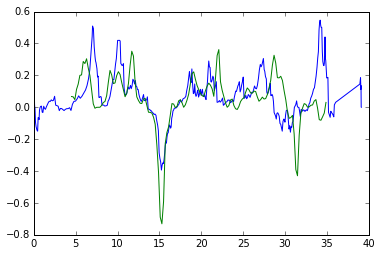

In [185]:
state_log = np.float32(state_log)
plt.plot(state_log[:, 0], state_log[:, 5])
plt.plot(4.5 + np.arange(len(trackmap_curvature)) * MAP_SPACING, trackmap_curvature)

In [175]:
plt.plot(state_log[:, 0], np.sqrt(state_log[:, 5]))

TypeError: list indices must be integers, not tuple

In [60]:
import sim
sim.track.shape

(4, 105)

In [61]:
ks = np.float32([sim.get_curvature(s) for s in range(105)])

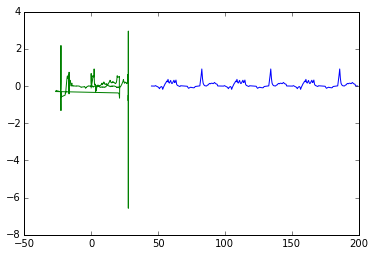

In [91]:
state_log = np.float32(state_log)

offset = 45
laps = 3
plt.plot(MAP_SPACING*np.arange(104*laps) + offset, np.concatenate([trackmap_curvature]*laps))
plt.plot(state_log[:, 0], state_log[:, 5])
#plt.xlim(70, 200)

In [1625]:
def refine_s(mean_s, var_s, mean_k, var_k):
    ''' return new P(s | s', k) -- refine position estimate from curvature estimate '''
    s = np.arange(len(trackmap_curvature)) * MAP_SPACING  # s in meters
    tracklen = len(trackmap_curvature) * MAP_SPACING  # tracklen in meters
    sdist = ((s - mean_s) + tracklen/2) % tracklen - tracklen/2  # wrap distance around track

    # log-probability distribution over k:
    # P(s|k) ~ P(k|s)P(s)
    # P(s) is given
    # P(k|s) is the likelihood of trackmap curvature k w.r.t. mean_k / var_k
    Ls = -(trackmap_curvature - mean_k)**2 / (2 * var_k) - sdist**2 / (2 * var_s)
    # FIXME: need to get the joint probability P(s, k) mean and covariance
    # so i guess we sample all integer s, and compute s and k
    
    # make log(mode) = 0 so we avoid overflow
    ps = np.exp(Ls - np.max(Ls))
    ps /= np.sum(ps)
    
    # plt.plot(s, ps)
    
    X = np.vstack([sdist, trackmap_curvature]).T
    mean = np.dot(ps, X)
    mean[0] += mean_s
    Rk = np.dot((X - mean).T, np.dot(np.diag(ps), (X - mean)))
    yk = mean - np.array([mean_s, mean_k])
    #var = np.dot(ps, (sdist)**2)
    return yk, Rk

#plt.plot(np.arange(len(trackmap_curvature)) * MAP_SPACING,
#         np.exp(refine_s(350, 1000**2, 0.2, 0.1**2)))
#snew = np.float32([refine_s(s, 10**2, 0.01, 0.01**2) for s in np.linspace(0, tracklen, 100)])
#s = np.linspace(0, tracklen, 100)
#plt.plot(s, snew[:, 0] - s)
#plt.plot(s, snew[:, 0] + np.sqrt(snew[:, 1]) - s)
#plt.plot(s, snew[:, 0] - np.sqrt(snew[:, 1]) - s)

#snew = np.float32([refine_s(s, 10**2, -0.01, 0.015**2) for s in np.linspace(0, tracklen, 100)])
#s = np.linspace(0, tracklen, 100)
#plt.plot(s, snew[:, 0] - s)
#plt.plot(s, snew[:, 0] + np.sqrt(snew[:, 1]) - s)
#plt.plot(s, snew[:, 0] - np.sqrt(snew[:, 1]) - s)

refine_s(29, 10**2, -0.005, 0.3**2)

(array([-0.0487232 ,  0.02175922]), array([[ 934.48193332,   -0.08572301],
        [  -0.08572301,    0.00475572]]))

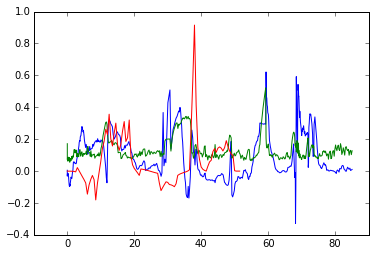

In [352]:
sl = np.float32(state_log)
plt.plot(sl[:, 0], sl[:, 5])
plt.plot(sl[:, 0], np.sqrt(sl[:, 10]))
plt.plot(np.linspace(0, TRACK_LEN, len(trackmap_curvature)), trackmap_curvature)

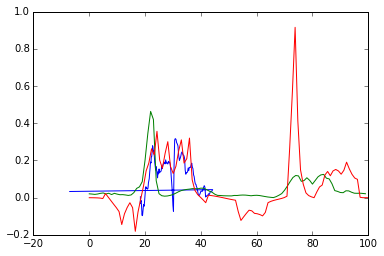

In [366]:
plt.plot((sl[:200, 0] - sl[199, 0]) % TRACK_LEN - 7, sl[:200, 5])

plt.plot(track_location_prob(sl[:200]) / 20)
plt.plot(np.linspace(0, 100, len(trackmap_curvature)), trackmap_curvature)

In [ ]:
plt.xlim([-1, 1])
plt.plot(udplane[nz][:, 0], -udplane[nz][:, 1], '.')

In [ ]:
plt.plot(nz[1], -nz[0], '.')

In [ ]:
def circlefit(xs, ys):
    # suuuuuuuucks, don't use
    n = len(xs)
    A = np.vstack([np.ones(n), xs, ys, (xs)**2 + (ys)**2])
    print A[1]**2 + A[2]**2 - 4*A[3]
    print A
    A = np.dot(A.T, A)
    U = np.linalg.cholesky(A).T
    print U
    a = np.linalg.det(U[:3, (1,2,3)])
    b = -np.linalg.det(U[:3, (0,2,3)])
    c = np.linalg.det(U[:3, (0,1,3)])
    d = -np.linalg.det(U[:3, (0,1,2)])
    # print a + b*xs + c*ys + d*(xs**2 + ys**2)
    cx = -b/(2*d)
    cy = -c/(2*d)
    print 'center', cx, cy
    r = np.sqrt(cx**2 + cy**2 - a/d)
    print 'r', r
    
    t = np.linspace(0, 2*np.pi, 100)
    plt.plot(r*np.cos(t) + cx, r*np.sin(t) + cy)

    

plt.plot(udplane[nz][:, 0], udplane[nz][:, 1], '.')
circlefit(udplane[nz][:, 0], udplane[nz][:, 1])
#circlefit(3*np.cos(t) + 0, 3.0001*np.sin(t) - 0.5)

[-0.17371614 -0.23962462  0.01685847]
29.6586774588


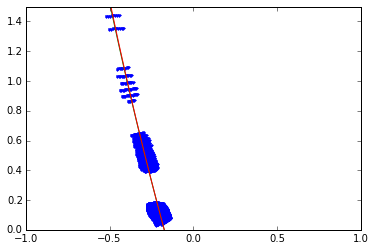

In [201]:
def quadfit(xs, ys):
    n = len(ys)
    X = np.vstack([np.ones(n), ys, ys**2]).T
    XTX = np.dot(X.T, X)
    B = np.linalg.solve(XTX, np.dot(X.T, xs))
    print B
    t = np.linspace(0, 1.5, 30)
    plt.plot(B[0] + B[1]*t + B[2]*t**2, t)
    # psie is atan(dx/dy @ y=0) which is just B[1]
    # and ye is B[0] sec(psie) i guess
    psie = np.arctan(-B[1])
    # for curvature we can match d^2x/dy^2 w/ a circle
    # projected against the tangent line
    # hm, so what's the derivative of a circle at the top? it's exactly r
    # so 2 B[2] is our curvature exactly!
    t = np.linspace(0, 2*np.pi, 1000)
    r = 0.5/B[2]
    print r
    cx = B[0] + r*np.cos(psie)
    cy = r*np.sin(psie)
    #cy = r * np.sin(psie)
    plt.plot(r * np.cos(t) + cx, r * np.sin(t) + cy)
    
    

plt.xlim(-1, 1)
plt.ylim(0, 1.5)
plt.plot(udplane[nz][:, 0], -udplane[nz][:, 1], '.')
quadfit(udplane[nz][:, 0], -udplane[nz][:, 1])

In [92]:
ss = np.dot(np.random.randn(1000, 2), np.array([[1.0, -4.0], [0.0, 0.1]]))
np.dot(ss.T, ss) / 1000

array([[  0.97109167,  -3.88181584],
       [ -3.88181584,  15.5269255 ]])

In [93]:
np.linalg.cholesky(np.dot(np.array([[1.0, -4.0], [0.0, 0.1]]).T, np.array([[1.0, -4.0], [0.0, 0.1]])))

array([[ 1. ,  0. ],
       [-4. ,  0.1]])

In [98]:
ss = np.dot(np.array([[1.0, 0.0], [-4.0, 0.1]]), np.random.randn(2, 1000)).T
np.dot(ss.T, ss) / 1000

array([[  1.01739916,  -4.06648632],
       [ -4.06648632,  16.26337419]])

In [107]:
MAP_SPACING

0.5345454545454545

In [134]:
len(trackmap_curvature) * MAP_SPACING

55.592727272727274

In [217]:
state_log = np.float32(state_log)

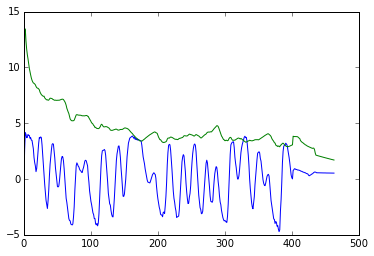

In [232]:
#plt.plot(state_log[:, 3] * state_log[:, 4])
plt.plot(state_log[:, 3])
plt.plot(state_log[:, 4])

In [108]:
np.log(9)

2.1972245773362196

In [111]:
P = np.diag([2, 1, 0.1, 10, 1,
             0.18, 0.29, 0.18, 0.15, 0.076, 0.17, 0.35, 0.35])**2
np.diag(P)

array([   4.      ,    1.      ,    0.01    ,  100.      ,    1.      ,
          0.0324  ,    0.0841  ,    0.0324  ,    0.0225  ,    0.005776,
          0.0289  ,    0.1225  ,    0.1225  ])